In [1]:
import ROOT
import ostap.fixes.fixes
from ostap.core.core import cpp, Ostap
from ostap.core.core import pwd, cwd, ROOTCWD
from ostap.core.core import rootID, funcID, funID, fID, histoID, hID, dsID
from ostap.core.core import VE
from ostap.histos.histos import h1_axis, h2_axes, h3_axes
from ostap.histos.graphs import makeGraph, hToGraph, hToGraph2, hToGraph3, lw_graph
import ostap.trees.trees
import ostap.trees.cuts
import ostap.histos.param
import ostap.histos.compare
import ostap.io.root_file
import ostap.math.models
import ostap.fitting.roofit 
import ostap.fitting.models as Models
canv = ROOT.TCanvas("canv","canv",800,400)

Welcome to JupyROOT 6.20/06


In [2]:
Ed = 0.025 *0.001 # MeV, Defect energy
ER = 0.0136*0.001 # MeV, Rydberg constant
#s_light = 2.997925*(10**10) # cm/s
aem = 931.4941 # MeV/c2
M = (0.691*62.9295975 + 0.309*64.9277895)*aem; # MeV: Cu average mass
Z = 29.
m = 0.51099895 # MeV;
alpha = 1./137.;
from math import pi

In [4]:
def E_max(E, MM = M, mm = m):
    return 2.*E*(E+2.*mm)/MM

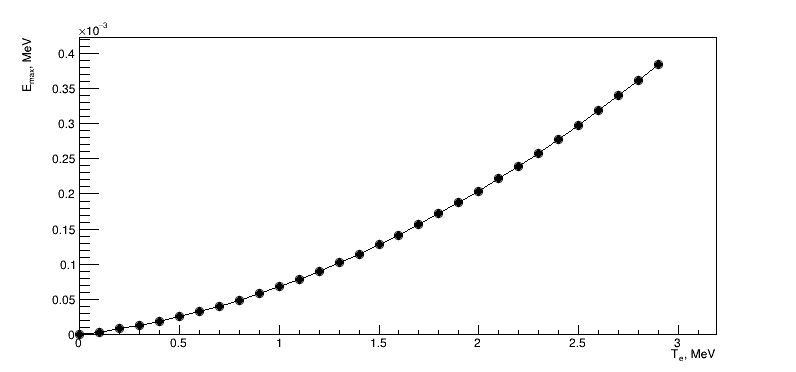

In [5]:
Ee = []
emax = []
for i in range(30):
    Ee.append(0.1*i)
    emax.append(E_max(0.1*i))
gr_emax = makeGraph(Ee,emax)
gr_emax.SetMarkerStyle(20)
gr_emax.SetTitle("")
gr_emax.GetXaxis().SetTitle("T_{e}, MeV")
gr_emax.GetYaxis().SetTitle("E_{max}, MeV")
gr_emax.Draw("APL")
canv.Draw()

In [6]:
pia02 = 88.*1000.*1000.
def xs_max(EEd, ZZ=Z, MM=M):
    return 8.*pia02*pow(ER*ZZ,2)/(MM*EEd)

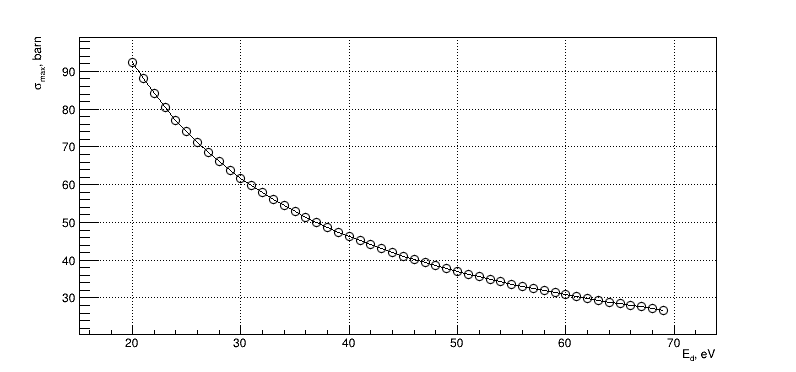

In [7]:
ed_list = []
xs_max_list = []
for i in range(20,70):
    ed_list.append(1.*i)
    xs_max_list.append( xs_max(0.001*0.001*i) )
gr_xsmax = makeGraph( ed_list, xs_max_list)
gr_xsmax.SetMarkerStyle(24)
gr_xsmax.SetTitle("")
gr_xsmax.GetXaxis().SetTitle("E_{d}, eV")
gr_xsmax.GetYaxis().SetTitle("#sigma_{max}, barn")
gr_xsmax.Draw("APL")
ROOT.gPad.SetGridx()
ROOT.gPad.SetGridy()
canv.Draw()

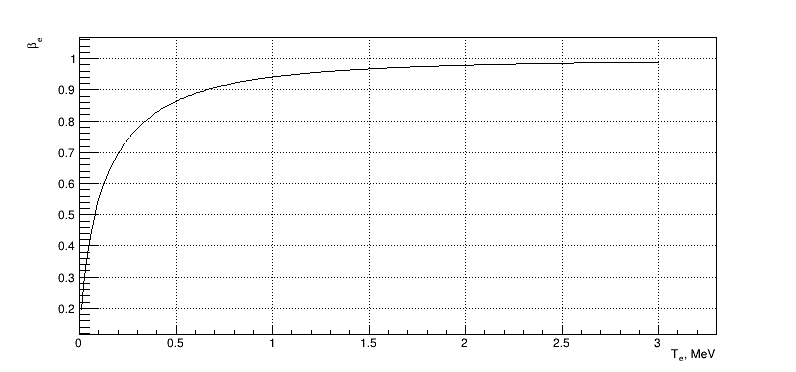

In [8]:
from math import sqrt
def beta_e(T,mm=0.51099895):
    return sqrt(1.-pow(mm/(T+mm),2))
T_list = []
beta_list = []
for ii in range(1,301):
    T_list.append(0.01*ii)
    beta_list.append(beta_e(0.01*ii))
gr_beta = makeGraph( T_list, beta_list)
gr_beta.SetTitle("")
gr_beta.GetXaxis().SetTitle("T_{e}, MeV")
gr_beta.GetYaxis().SetTitle("#beta_{e}")
gr_beta.Draw("AL")
ROOT.gPad.SetGridx()
ROOT.gPad.SetGridy()
canv.Draw()

In [9]:
from math import log
def xs(T, Ed, ZZ=Z):
    beta = beta_e(T)
    alpha = ZZ / 137.
    xs0 = 4.*pia02*pow(ER,2)*E_max(T)*pow(ZZ,2)*(1-pow(beta,2))/(Ed*pow(m*beta*beta,2))
    A1 = 2.*pi*alpha*beta*sqrt(Ed/E_max(T))
    B1 = 2.*pi*alpha*beta
    B2 = beta*(beta+pi*alpha)*log(E_max(T)/Ed)
    BB = Ed*(1.+B1+B2)/E_max(T)
    xs = xs0*(1.+A1-BB)
    return xs

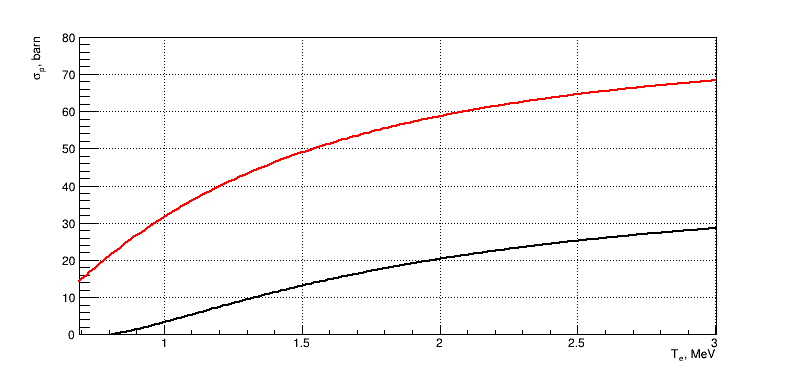

In [11]:
xs_list_25=[]
xs_list_50=[]
for T in T_list:
    xs_list_25.append(xs(T,0.025*0.001))
    xs_list_50.append(xs(T,0.050*0.001))
gr_25 = makeGraph( T_list, xs_list_25)
gr_50 = makeGraph( T_list, xs_list_50)
gr_25.SetTitle("")
gr_50.SetTitle("")
gr_25.SetLineWidth(2)
gr_50.SetLineWidth(2)
gr_25.SetLineColor(2)
gr_25.GetXaxis().SetTitle("T_{e}, MeV")
gr_50.GetXaxis().SetTitle("T_{e}, MeV")
gr_25.GetYaxis().SetTitle("#sigma_{p}, barn")
gr_50.GetYaxis().SetTitle("#sigma_{p}, barn")
gr_50.GetXaxis().SetRangeUser(0.7,3)
gr_50.GetYaxis().SetRangeUser(0,80)
gr_50.Draw("AL")
gr_25.Draw("L same")
ROOT.gPad.SetGridx()
ROOT.gPad.SetGridy()
canv.Draw()

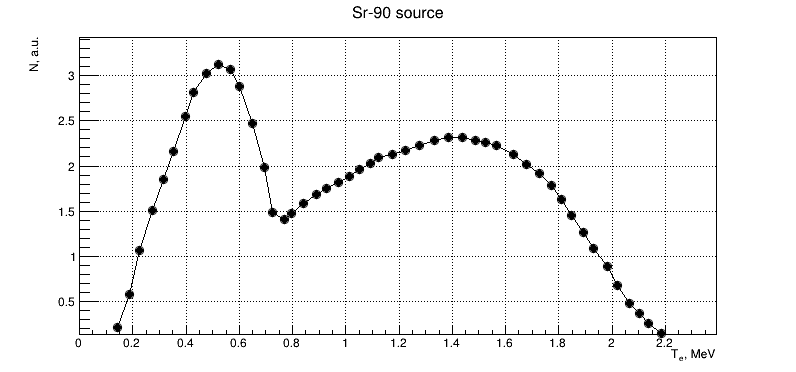

In [12]:
T_sp=[]
N_sp=[]
sfile = open("source-data.txt","r")
for line in sfile:
    if len(line)>2:
        T_sp.append( float(line[:-1].split(" ")[0]) )
        N_sp.append( float(line[:-1].split(" ")[1]) )
sfile.close()
gr_sp = makeGraph(T_sp,N_sp)
gr_sp.SetMarkerStyle(20)
gr_sp.SetTitle("Sr-90 source")
gr_sp.GetXaxis().SetTitle("T_{e}, MeV")
gr_sp.GetYaxis().SetTitle("N, a.u.")
gr_sp.Draw("APL")
canv.Draw()

Max N_sp = 3.125348189415042


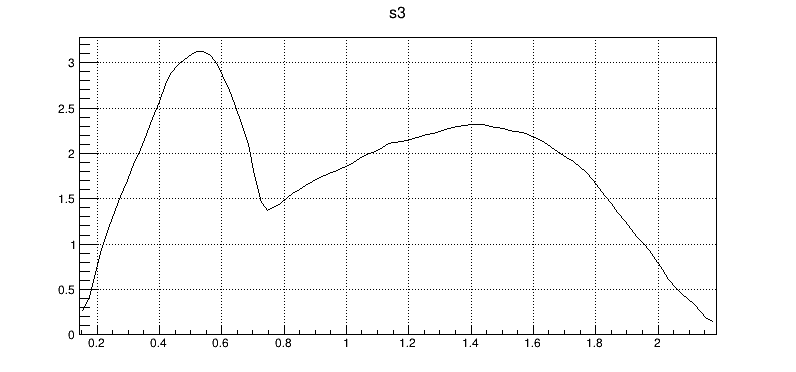

In [13]:
print("Max N_sp = " + str(max(N_sp)))
s3 = ROOT.TSpline3("s3",gr_sp)
s3.Draw()
canv.Draw()

In [14]:
def xs25(T):
    if T<0.490 or T>2.2:
        return 0
    return xs(T,0.025*0.001)
def xs50(T):
    if T<0.805 or T>2.2:
        return 0
    return xs(T,0.050*0.001)

In [15]:
Nevt=1000000
av25=0.
av50=0.
Ngen=0
for ev in range(Nevt):
    rT=0.2+2.*ROOT.gRandom.Rndm()
    rN=max(N_sp)*ROOT.gRandom.Rndm()
    if s3.Eval(rT)>rN:
        av25 += xs25(rT)
        av50 += xs50(rT)
        Ngen += 1
av25 = av25 / float(Ngen)
av50 = av50 / float(Ngen)
print("Averaged XS (Ed=25 eV) = " + str(av25) )
print("Averaged XS (Ed=50 eV) = " + str(av50) )


Averaged XS (Ed=25 eV) = 30.14398623651877
Averaged XS (Ed=50 eV) = 6.892492337553466


In [71]:
rho_Cu = 8.96 # gr/cm3
Na = 60.22 # *10^24 1/mol
M_Cu = 63.546 # gr/mol
d_Cu = 0.0035 # cm
def Np(xs):
    return xs*rho_Cu*Na*d_Cu / M_Cu
print("Np per 1 electron (Ed=25eV) = " + str(Np(av25)))
print("Np per 1 electron (Ed=50eV) = " + str(Np(av50)))

Np per 1 electron (Ed=25eV) = 0.8958375647952148
Np per 1 electron (Ed=50eV) = 0.20483533606325893


In [70]:
rho_Cu*Na/M_Cu

8.491033267239482

In [78]:
print(10**8*10**4*Np(xs25(1))/(rho_Cu*Na*d_Cu*10**24 / M_Cu))
print(10**8*10**4*Np(xs50(1))/(rho_Cu*Na*d_Cu*10**24 / M_Cu))


3.1515007459585805e-11
3.2404743439812714e-12
